In [1]:
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Activation, Flatten
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [0]:
import sklearn
from sklearn.utils import shuffle
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [0]:
#import the csv
data = pd.read_csv('bpi_12_w_no_repeat.csv')
# np.sum(data.isna())


In [0]:
#to make the caseID start from zero
data['CaseID'] = data['CaseID'] - 173688 

In [0]:
#given the caseID, array 'numarray' outputs the number of events in  that particular caseID trace.
caseS = pd.Series(data['CaseID'] )
numarray = caseS.value_counts()

In [6]:
# outputs the number of traces where the number of events in the particular trace is the index of below Series(CaseID).
numcaseID = pd.value_counts(data['CaseID']).value_counts()
maxlen = max(numcaseID.index)
maxlen

13

In [7]:
actS = pd.Series(data['ActivityID'] )
actS.value_counts()
classes = actS.max()
#zero will be for end of trace
print("number of classes(zero not included which will be denoted later as end of trace) :" +str(classes))

number of classes(zero not included which will be denoted later as end of trace) :6


In [0]:
#converting it into datetime datatype of pandas for easy access of date, time and other operations.
data['datetime'] = pd.to_datetime(data['CompleteTimestamp'])
data.drop(['CompleteTimestamp'], axis=1, inplace=True)
# data.head()

In [0]:
#set finds the unique numbers in caseID i.e list all the unique caseIDs.
ca_uni = list(set(data['CaseID'].values))
# len(ca_uni)

In [0]:
#datetime is shifted to find elapsed or concerned type of time further down the line.
data['dapa'] = data['datetime'].shift(1)
# data.head()

In [0]:
#difference of datetime is timedelta type in pandas which has a function called .total_seconds()
data['elapsed'] = data['datetime'] - data['dapa']
elapsec = [x.total_seconds() for x in data['elapsed'] ]
data['elap'] = elapsec
data.drop(columns=['elapsed','dapa'],inplace = True)
# data.head(50)


In [0]:
#case at all times denote the index of data panda, and ca_uni contains unique caseIDs, we increment case with a[i] amount i.e the number of events in that particular trace denoted by i (element of ca_uni).
case = 0
for i in ca_uni:
  data.loc[case,'elap'] = 0
  case += numarray[ i ]
  
# data.head(10)
  
  

In [0]:
#converted the seconds into days
lis = [(x.hour*3600 + x.minute*60 + x.second) for x in data['datetime']]
data['from_midnight']  =lis
# data.head()

In [0]:
#we notice by below graphs that most stuff happened during the evening/night
# data['from_midnight'].hist()

In [0]:
#we find the from_midnight and from_sun attributes using .weekday function of datetime object and converted everything into time(days) scale.
li = [x.weekday()*86400 for x in data['datetime']]
data['from_sun'] = li
data['from_sun'] = (data['from_sun'] +  data['from_midnight'])/86400
data['from_midnight'] = (data['from_midnight'])/86400
data['elap'] = (data['elap'])/86400
# data.head()

In [0]:
#we see that no event occurred on Sunday and least events happenned on Tuesday most on Monday.
#data['from_sun'].hist()

In [17]:
print("Below is the compilation of information of all the data we conjured.")
print(data.describe())

Below is the compilation of information of all the data we conjured.
             CaseID    ActivityID          elap  from_midnight      from_sun
count  29410.000000  29410.000000  29410.000000   29410.000000  29410.000000
mean   20374.844747      3.782013      0.030041       0.577610      3.053570
std    11782.888965      1.697673     10.626620       0.366810      1.614895
min        0.000000      1.000000    -85.836424       0.000012      0.284398
25%     9744.000000      3.000000      0.000000       0.160856      1.778605
50%    20872.500000      4.000000      0.000000       0.773119      2.958785
75%    30603.500000      5.000000      0.672925       0.875720      4.200752
max    40688.000000      6.000000     89.548322       0.999988      6.955370


In [0]:
# data.head()

In [19]:
# data.head(10)
data.describe()
# we see below if any null values are there, the results were zero in all the columns
np.sum(data.isna())

CaseID           0
ActivityID       0
datetime         0
elap             0
from_midnight    0
from_sun         0
dtype: int64

In [0]:
#gcid denotes the group number categorized according to the caseID or the trace number.
gcid = data.groupby('CaseID')


In [0]:
#categorizing the data by individual traces
act = []#contains all the events of a particular trace as one element.
time = []#contains timestamp of all events of a particular trace as one element
ofea = []#contains ofea(other features) like elapsed time, time from midnight, time from last sunday of all traces as one element
for cid in ca_uni:
  temp = gcid.get_group(cid)
  act.append(temp['ActivityID'].values)
  time.append(temp['datetime'].values)
  ofea.append(temp[['elap','from_midnight','from_sun']].values)


In [0]:
#padding the above arrays with the maximum number of events possible in our dataset which is 13 i.e maximum of 13 element was found in a trace
padded_act = pad_sequences(act, padding = "post", maxlen = maxlen)
padded_time = pad_sequences(time, padding = "post", maxlen = maxlen, dtype = 'datetime64[ns]')
padded_ofea = pad_sequences(ofea, padding = "post", maxlen = maxlen, dtype = 'float64')

In [0]:
#finding one-hot encoding of the padded activity for each concatenation and access later.
X = to_categorical(
    padded_act,
    num_classes= classes+1,
    dtype = 'int'
)
# X.shape

In [0]:
#concatinating other features into the one-hot encoding making the shape(-1,13,10) for this dataset.
X = np.concatenate((X,padded_ofea) , axis = 2)


**PREFIX = decide here**

In [0]:
# padded_time.shape

In [0]:
#decide the length of prefix here
prefix = 2

In [0]:
#We remove all the traces where the end of trace has already occurerred as they would make our model bias if taken 
X_train = X[X[:,prefix-1,0] == 0]
time = padded_time[X[:,prefix-1,0] == 0]
# we also keep the corresponding timestamps in time array

In [29]:
print("The shape of the data before cutting it for training and validation: "+str(X_train.shape))

The shape of the data before cutting it for training and validation: (7469, 13, 10)


In [0]:
# X_train[:,:prefix,:].shape

In [31]:
#For our purposes we take 80% of data for training and rest for testing results.  
till = int(X_train.shape[0] *0.8)
X_test = X_train[till:]
X_train = X_train[:till]
# X_test.shape
print("The shape of the training data "+str(X_train.shape))
print("The shape of the testing data "+str(X_test.shape))

The shape of the training data (5004, 13, 10)
The shape of the testing data (2465, 13, 10)


In [0]:
#we do this for time array previously formed as well
time_test = time[till:]
time_train = time[:till]

In [0]:
nb_epoch = 50
batch_size = 16#since number of traces are small, we take small batch_size
hidden_units = 100
num_features = 10


In [0]:
class PlotLosses(keras.callbacks.Callback):
  
    '''class to implement callback in keras
    it would graph the losses as the model trains'''
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.xlabel('epochs')
        plt.ylabel('loss in MAE')
        plt.legend()
        plt.show();
        
plot = PlotLosses()

**activity prediciton**

In [37]:
#model is separate model for only activity prediction hence no shared layer
model1 = Sequential()
model1.add(LSTM(hidden_units, input_shape = (prefix,num_features),return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM( 100))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(classes+1,activation='softmax'))

print(model1.summary())
model1.compile(loss = 'mean_squared_error', optimizer='adam',metrics = ['accuracy'])

W0703 20:03:09.781550 140513673705344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 20:03:09.827364 140513673705344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 20:03:09.835277 140513673705344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 20:03:10.097552 140513673705344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0703 20:03:10.108967 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2, 100)            44400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 125,907
Trainable params: 125,707
Non-trainable params: 200
_________________________________________________________________
No

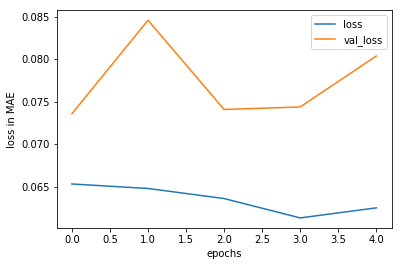

In [768]:
history = model1.fit(X_train[:,:prefix,:], X_train[:,prefix,:7], epochs=15, batch_size=batch_size,validation_split=0.2,callbacks=[plot]
          ,verbose=0)

In [769]:
accr = model1.evaluate(X_test[:,:prefix,:],X_test[:,prefix,:7])
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

192/192 [==============================] - 0s 259us/step
Test set
  Loss: 0.075
  Accuracy: 0.552


**Time prediction**

In [38]:
#model2 calcualtes time only hence no shared layer
model2 = Sequential()
model2.add(LSTM(hidden_units,input_shape = (prefix,num_features),return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(100 ))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(128,activation='relu'))

model2.add(Dense(32,activation='relu'))
model2.add(Dense(1,activation='linear'))

print(model2.summary())
model2.compile(loss = 'mean_squared_error', optimizer='adam',metrics = ['mae'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 2, 100)            44400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 100)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               12928     
__________

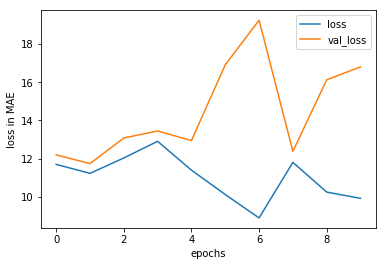

In [779]:
history = model2.fit(X_train[:,:prefix,:], X_train[:,prefix,7], epochs=50, batch_size=batch_size,validation_split=0.2,callbacks=[plot]
          ,verbose=0)

In [780]:
accr = model2.evaluate(X_test[:,:prefix,:],X_test[:,prefix,7])
print('Test set\n  Loss: {:0.3f}\n  MAE: {:0.3f}'.format(accr[0],accr[1]))

192/192 [==============================] - 0s 241us/step
Test set
  Loss: 8.578
  MAE: 1.040


**shared layer of activity and time**

In [0]:
from keras.models import Model
from keras.layers import *    


In [40]:
#shared model where first layer is common then two layers branch out specializing in activity and time prediction respectively
inp = Input((prefix,num_features),name='inp')  

x = LSTM(hidden_units,input_shape = (prefix,num_features),return_sequences=True)(inp)
x = Dropout(0.6)(x)
temp1 =LSTM(100 )(x)
temp = LSTM(100)(x)

temp = BatchNormalization()(temp)
temp = Activation('relu')(temp)
temp= Dropout(0.6)(temp)
temp1= Dropout(0.6)(temp1)
temp = Dense(128,activation='relu')(temp)
temp = BatchNormalization()(temp)
temp = Activation('relu')(temp)
temp= Dropout(0.6)(temp)

act_output = Dense(classes+1, activation='softmax', kernel_initializer='glorot_uniform', name='act_output')(temp1)
time_output = Dense(1, kernel_initializer='glorot_uniform', name='time_output')(temp)


model3 = Model(inputs=[inp], outputs=[act_output, time_output])
print(model3.summary())
model3.compile(loss={'act_output':'categorical_crossentropy', 'time_output':'mean_squared_error'}, optimizer='Adam',metrics = {'act_output':'accuracy', 'time_output':'mae'})


W0703 20:03:25.425271 140513673705344 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0703 20:03:26.095467 140513673705344 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0703 20:03:26.121759 140513673705344 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0703 20:03:26.239953 140513673705344 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0703 20:03:26.310395 140513673705344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp (InputLayer)                (None, 2, 10)        0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 2, 100)       44400       inp[0][0]                        
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2, 100)       0           lstm_5[0][0]                     
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 100)          80400       dropout_5[0][0]                  
__________________________________________________________________________________________________
batch_norm

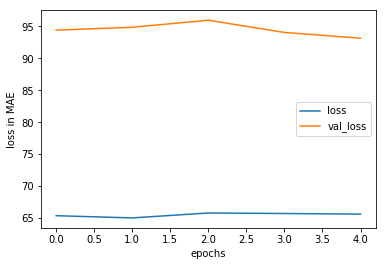

In [108]:
history = model3.fit(X_train[:,:prefix,:], {'act_output':X_train[:,prefix,:7], 'time_output':X_train[:,prefix,7]}, epochs=50, batch_size=batch_size,validation_split=0.2,callbacks=[plot]
          ,verbose=0)

In [110]:
accr = model3.evaluate(X_test[:,:prefix,:],{'act_output':X_test[:,prefix,:7], 'time_output':X_test[:,prefix,7]})
print('Test set\n  Loss: {:0.3f}\n  act_output_acc: {:0.3f} \n  time_output_mean_absolute_error: {:0.3f}'.format(accr[0],accr[3],accr[4]))

1494/1494 [==============================] - 0s 92us/step
Test set
  Loss: 74.167
  act_output_acc: 0.675 
  time_output_mean_absolute_error: 5.463


In [0]:
# model3.save("p5s1bpi.h5")

In [0]:
from keras.models import load_model
 
# # load model
# p2 = load_model('p5s1bpi.h5')
# # summarize model.
# p2.summary()

**Attention layer implementation**

**PREFIX = decide here**

In [0]:
class Attention(Layer):
    '''attention layer which inputs a layer 
    and according to the shape of the current 
    input, outputs augmented layer '''
    def __init__(self, nb_head, size_per_head, **kwargs):
        self.nb_head = nb_head
        self.size_per_head = size_per_head
        self.output_dim = nb_head*size_per_head
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.WQ = self.add_weight(name='WQ', 
                                  shape=(input_shape[0][-1], self.output_dim),
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.WK = self.add_weight(name='WK', 
                                  shape=(input_shape[1][-1], self.output_dim),
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.WV = self.add_weight(name='WV', 
                                  shape=(input_shape[2][-1], self.output_dim),
                                  initializer='glorot_uniform',
                                  trainable=True)
        super(Attention, self).build(input_shape)
        
        
#     def Mask(self, inputs, seq_len, mode='mul'):
#         if seq_len == None:
#             return inputs
#         else:
#             mask = K.one_hot(seq_len[:,0], K.shape(inputs)[1])
#             mask = 1 - K.cumsum(mask, 1)
#             for _ in range(len(inputs.shape)-2):
#                 mask = K.expand_dims(mask, 2)
#             if mode == 'mul':
#                 return inputs * mask
#             if mode == 'add':
#                 return inputs - (1 - mask) * 1e12
              
    def call(self, x):
        if len(x) == 3:
            Q_seq,K_seq,V_seq = x
            Q_len,V_len = None,None
        elif len(x) == 5:
            Q_seq,K_seq,V_seq,Q_len,V_len = x
        Q_seq = K.dot(Q_seq, self.WQ)
        Q_seq = K.reshape(Q_seq, (-1, K.shape(Q_seq)[1], self.nb_head, self.size_per_head))
        Q_seq = K.permute_dimensions(Q_seq, (0,2,1,3))
        K_seq = K.dot(K_seq, self.WK)
        K_seq = K.reshape(K_seq, (-1, K.shape(K_seq)[1], self.nb_head, self.size_per_head))
        K_seq = K.permute_dimensions(K_seq, (0,2,1,3))
        V_seq = K.dot(V_seq, self.WV)
        V_seq = K.reshape(V_seq, (-1, K.shape(V_seq)[1], self.nb_head, self.size_per_head))
        V_seq = K.permute_dimensions(V_seq, (0,2,1,3))
        A = K.batch_dot(Q_seq, K_seq, axes=[3,3]) / self.size_per_head**0.5
        A = K.permute_dimensions(A, (0,3,2,1))
#         A = self.Mask(A, V_len, 'add')
        A = K.permute_dimensions(A, (0,3,2,1))    
        A = K.softmax(A)
        O_seq = K.batch_dot(A, V_seq, axes=[3,2])
        O_seq = K.permute_dimensions(O_seq, (0,2,1,3))
        O_seq = K.reshape(O_seq, (-1, K.shape(O_seq)[1], self.output_dim))
#         O_seq = self.Mask(O_seq, Q_len, 'mul')
        return O_seq
      
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], self.output_dim)

In [46]:
#shared model where first layer is common then two layers branch out specializing in activity and time prediction respectively
inp = Input((prefix,num_features),name='inp')  
x = LSTM(hidden_units,return_sequences=True)(inp)
temp= Dropout(0.6)(temp)
temp = Attention(2, 64)([x, x, x])  #output: [batch_size, time_step, nb_head*size_per_head]


temp = BatchNormalization()(temp)
temp = Activation('relu')(temp)
temp= Dropout(0.6)(temp)
temp = Dense(128,activation='relu')(temp)
temp= Dropout(0.6)(temp)
temp1 = Dense(128,activation='relu')(temp)
temp = Flatten()(temp)
temp1 = Flatten()(temp1)

act_output = Dense(classes+1, activation='softmax', kernel_initializer='glorot_uniform', name='act_output')(temp1)
time_output = Dense(1, kernel_initializer='glorot_uniform', name='time_output')(temp)


attmodel = Model(inputs=[inp], outputs=[act_output, time_output])
print(attmodel.summary())
attmodel.compile(loss={'act_output':'categorical_crossentropy', 'time_output':'mean_squared_error'}, optimizer='Adam',metrics = {'act_output':'accuracy', 'time_output':'mae'})


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp (InputLayer)                (None, 2, 10)        0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 2, 100)       44400       inp[0][0]                        
__________________________________________________________________________________________________
attention_2 (Attention)         (None, 2, 128)       38400       lstm_9[0][0]                     
                                                                 lstm_9[0][0]                     
                                                                 lstm_9[0][0]                     
__________________________________________________________________________________________________
batch_norm

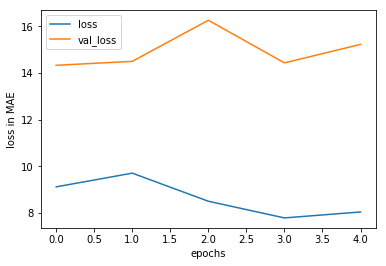

In [762]:
history = attmodel.fit(X_train[:,:prefix,:], {'act_output':X_train[:,prefix,:7], 'time_output':X_train[:,prefix,7]}, epochs=5, batch_size=batch_size,validation_split=0.2,callbacks=[plot]
          ,verbose=0)

In [763]:
accr = attmodel.evaluate(X_test[:,:prefix,:],{'act_output':X_test[:,prefix,:7], 'time_output':X_test[:,prefix,7]})
print('Test set\n  Loss: {:0.3f}\n  act_output_acc: {:0.3f} \n  time_output_mean_absolute_error: {:0.3f}'.format(accr[0],accr[3],accr[4]))

192/192 [==============================] - 0s 285us/step
Test set
  Loss: 7.283
  act_output_acc: 0.396 
  time_output_mean_absolute_error: 0.780


In [0]:
# Suffix prediction and remaining cycle time prediction starts here
prefix =3

In [185]:
# similar process from above where we remove the traces who fall short of the prefix length taken
X_train = X[X[:,prefix-1,0] == 0]
time = padded_time[X[:,prefix-1,0] == 0]
# time.shape

(5704, 13)

In [186]:
#data is divided into test and train
till = int(X_train.shape[0] *0.8)
X_test = X_train[till:]
X_train = X_train[:till]
# X_test.shape

(1141, 13, 10)

In [0]:
time_test = time[till:]
time_train = time[:till]

In [0]:
import datetime

In [0]:
#The weights corresponding to different prefixes are saved and loaded here
p2 = load_model('p2s1bpi.h5')
p3 = load_model('p3s1bpi.h5')
p4 = load_model('p4s1bpi.h5')
p5 = load_model('p5s1bpi.h5')

In [0]:
#we calculate the previous time because we have to add the new elapsed time to it to form the new timestamp
prevtime = time_test[:,prefix - 1]


In [0]:
pref = prefix#because the value of prefix will change so we want to store it

In [0]:
#prevtime and last_time are same but used for different purposes in the code
last_time = time_test[:,prefix-1]
# last_time

In [0]:
# We take the ground truth value of the future four events timestamp
time_test = time_test[:,prefix:prefix+4]
# time_test

In [196]:
#seq will contain future suffix of each example in test case
#time_pred will contain the time of the above said predicted suffix
seq = []
time_pred = []
# endtime = []

for i in range(len(X_test)):
  seq.append([])
  time_pred.append([])
prefix=2
testX = X_test[:,:prefix,:]#we take the input according to the specified prefix
# print(prevtime[2])
testnum = 1
print("For instance we follow the test case with index 1 and see the predictions")
while(True):
  #pact is predicted activity in one-hot encoded form
  #ptime is predicted elapsed time in days.
  if (prefix == 2):
    pact,ptime=p2.predict(testX)
  elif (prefix == 3):
    pact,ptime=p3.predict(testX)
  elif (prefix == 4):
    pact,ptime=p4.predict(testX)
  elif (prefix == 5):
    pact,ptime=p5.predict(testX)
  else:
    #we predict only next 4 which is more than enough given the low number of events in the traces
    break
  
  preact = np.argmax(pact,axis = 1)
  #at this point for many traces end of trace i.e 0 would have occurred 
  #but we keep predicting forward and handle this issue afterwards in post-processing
  newtime = []
  for i in range( len(ptime)):
    newtime.append( np.timedelta64( int((ptime*86400)[:,0][i] )  ,'s') + prevtime[i] )
  newtime = np.array(newtime)
  

  for i in range( len(ptime)):
    seq[i].append(preact[i])
    time_pred[i].append(newtime[i])
  print ( "\n"+str(testnum)+":Next activity is " + str(preact[testnum]) + " performed at time "+ str(newtime[testnum]) + " (previous activity time:" + str(prevtime[testnum]) + ")")
  
  act = np.zeros(( len(ptime),7))
  prefix += 1
  for i in range( len(ptime)): 
    act[i,preact[i]] = 1
  act = act.reshape(-1,1,7)
  
  test = pd.DataFrame(newtime)
  mid = []
  sun = []
  elapsed = []
  for i in range( len(ptime)):
    mid.append( (test[0][i].hour*3600 + test[0][i].minute*60 + test[0][i].second)/84600 )
    sun.append( test[0][i].weekday() + mid[i] )
    elapsed.append( (test[0][i] - prevtime[i]).total_seconds()/86400 )
  mid = np.array(mid)
  sun = np.array(sun)
  elapsed = np.array(elapsed)
  mid = mid.reshape(-1,1,1)
  sun = sun.reshape(-1,1,1)
  elapsed = elapsed.reshape(-1,1,1)
  new = np.concatenate((act,mid,sun,elapsed),axis = 2 )
  X_new = np.concatenate ((testX,new) , axis = 1)
  #above, we extract information from the predicted data and concatenate it to our already given prefix to form
  #a new prefix to predict next activity and timestamp in the sequence.

#   truth = (preact != 0)
  prevtime = newtime
  testX = X_new
#   break

For instance we follow the test case with index 1 and see the predictions

1:Next activity is 6 performed at time 2012-01-26T15:26:51.000000000 (previous activity time:2012-01-18T21:39:55.000000000)

1:Next activity is 4 performed at time 2012-01-26T22:31:34.000000000 (previous activity time:2012-01-26T15:26:51.000000000)

1:Next activity is 6 performed at time 2012-01-29T03:15:47.000000000 (previous activity time:2012-01-26T22:31:34.000000000)

1:Next activity is 0 performed at time 2012-01-29T05:15:09.000000000 (previous activity time:2012-01-29T03:15:47.000000000)


In [0]:
#For each trace zero i.e end of trace would have occurred or worst case scenario end of trace,
# we note down the index of that using zerofirst
zerofirst = []
for li in seq:
  for i in range(len(li)):
    if (li[i] == 0 or i == len(li)-1):
      li[i:] = [0]*(len(li)- i)
      zerofirst.append(i)
      break
# max(zerofirst)   

In [0]:
prefix = pref

In [0]:
#we note down the ground truth suffix for comparison purpose
suffix = X_test[:,prefix:prefix+6-pref,:7]
# suffix.shape

In [200]:
#convert one-hot encoding to the actual value of the event i.e activity ID for comparion purposes
preact = np.argmax(suffix,axis = 2)
# list(preact[:5,:])
preact.shape

(1141, 3)

In [0]:
#similar to zerofirst but zerotest is for the ground truth suffix extracted earliar.
zerotest = []
for li in preact:
  for i in range(len(li)):
    if (li[i] == 0 or i == len(li)-1):
      li[i:] = [0]*(len(li)- i)
      zerotest.append(i)
      break
      
# max(zerotest)

In [202]:
len(zerotest)
time_test.shape

(1141, 4)

In [0]:
time_pred = np.array(time_pred)
# time_pred.shape


In [0]:
# i=0
# for li in time_pred:
#   lmao = zerofirst[i]
#   li[lmao:] = [0]*(len(li)- lmao)
#   i +=1

In [0]:
# time_test

In [0]:
# zerotest

In [0]:
#This is for remaining cycle time prediction, we calculate the last known timestamp from the ground truth suffix
i=0
last_rec = []
for li in time_test:
  lmao = zerotest[i]
  if (lmao == 0):
    last_rec.append(last_time[i])
    i+=1
    continue
  last_rec.append(li[lmao-1])
  i +=1

In [0]:
#This is for remaining cycle time prediction as well, 
# we calculate the last known timestamp from the predicted suffix

i=0
last_pred = []
for li in time_pred:
  lmao = zerofirst[i]
  if (lmao == 0  ):
#     print(i,last_time[i]);
    last_pred.append(last_time[i])
    i+=1
    continue
  last_pred.append(li[lmao-1])
  i +=1
    

In [209]:
#for the above two array created we find the difference in time 
diff = []

for i in range(len(last_pred)):
  if (last_pred[i] != 0):
    dt = last_pred[i]- last_rec[i]
    seconds = dt / np.timedelta64(1, 's')
    diff.append(abs(seconds/86400))
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


In [210]:
print(" the result of remaining time cycle prediciton in MAE is :"+ str(sum(diff)/len(diff)))

 the result of remaining time cycle prediciton in MAE is :8.00225092917195


In [0]:
#for suffix prediction we have to convert them into string format
#for each suffix we find the string version with last element as zero
lpred = []
for li in seq:
  s = ""
  flag = 1
  for x in li:
    if (x !=0 ):
#       if (x ==0):
#         flag =0
      s+=str(x)
  lpred.append(s)
  
  
# lpred

In [0]:
#similar to above, we find the ground truth string version of suffix
ltruth = []
for li in preact:
  s = ""
  flag = 1
  for x in li:
    if (x !=0 ):
#       if (x ==0):
#         flag =0
      s+=str(x)
  ltruth.append(s)
# ltruth

In [213]:
# print("Installing strsim to calculate DLS")
pip install strsim

In [214]:
from similarity.damerau import Damerau
#below are two example of how it works
damerau = Damerau()
print(damerau.distance('ABCDEF', 'ABDCE'))
print(damerau.distance('ABCDE', 'ABCDE'))


2
0.0


In [0]:
# ltruth

In [216]:
# we calculate the DLS for each suffix and add the result to damdist array
damdist = []
for i in range(len(lpred)):
  if ( (max(len(ltruth[i]),len(lpred[i]))) == 0):
      damdist.append(0)
  else:
      dist = damerau.distance(ltruth[i], lpred[i])/(max(len(ltruth[i]),len(lpred[i])))
      damdist.append(dist)
  
  
print("The DLS value for suffix is :"+str(100-sum(damdist)/len(damdist)*100))
# damdist

The DLS value for suffix is :23.53198948290968
